In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from joblib import load
import xgboost as xgb
import os as OS
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import shap
import json
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def dataset_import(file_path, mode, feature_name, os_tag, dfs_tag):
    dataset = pd.read_excel(file_path)
    dataset.replace(' ', pd.NA, inplace=True)
    included_col = feature_name[:]
    if os_tag != "":
        included_col.append(os_tag)
    if dfs_tag != "":
        included_col.append(dfs_tag)
    dataset.dropna(inplace=True, subset=included_col)
    dataset.head()

    assert mode == "all" or "hr_pos" or "hr_neg"
    if mode == "hr_pos":
        dataset = dataset[dataset["HR"]==1]
    elif mode == "hr_neg":
        dataset = dataset[dataset["HR"]==0]
    elif mode == "all":
        pass

    data = dataset[feature_name].values.tolist()
    if os_tag != "":
        os = dataset[os_tag].values.tolist()
    else:
        os = []
    
    if dfs_tag != "":
        dfs = dataset[dfs_tag].values.tolist()
    else:
        dfs = []
    return data, os, dfs

In [19]:
feature_name = ["Her-2 status", "Age", "Histologic type", "Intravascular cancer thrombus", "Endocrine therapy", "Radiation therapy", "Her-2 target therapy", "Ki67", "Stage"]
mode = "hr_neg"
output_dir = "./model_dict"
file_path = "./dataset.xlsx"
os_tag = "OS (5 years)"
dfs_tag = ""

if not OS.path.exists(output_dir):
    OS.makedirs(output_dir)

data, os, dfs = dataset_import(
    file_path=file_path,
    mode=mode,
    feature_name=feature_name,
    os_tag=os_tag,
    dfs_tag=dfs_tag
)

print(f"Dataset import suceess. Mode is {mode}")

Dataset import suceess. Mode is hr_neg


In [20]:
# x_train, x_test, y_train, y_test = train_test_split(data, os, test_size=0.2, stratify=os, random_state=240225)
x_test = data
y_test = os

rf_model = load(f"./model_dict_os5_remote/randomForest_{mode}.joblib")
xgb_model = xgb.Booster()
xgb_model.load_model(f"./model_dict_os5_remote/xgBoost_{mode}.json")
cgb_model = CatBoostClassifier()
cgb_model.load_model(f"./model_dict_os5_remote/catBoost_{mode}.json")
mlp_model = load(f"./model_dict_os5_bayes_remote/mlp_{mode}.joblib")

Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelBinarizer from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or

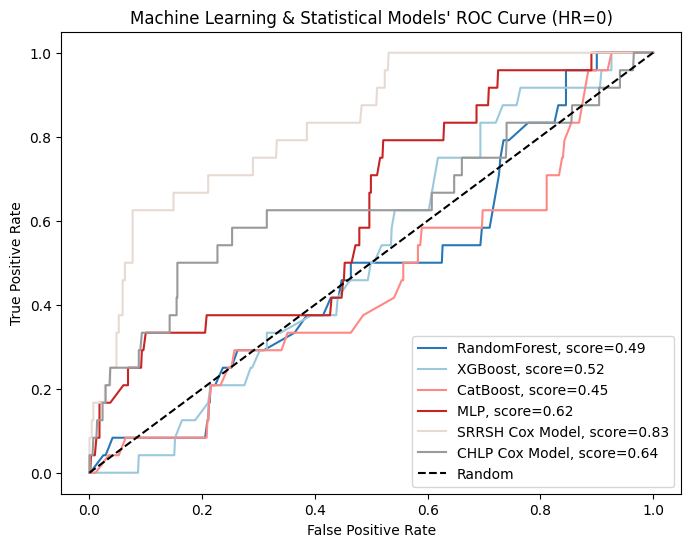

In [21]:
plt.figure(figsize=(8, 6))

y_pred = rf_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f'RandomForest, score={score:.2f}', color='#2878b5')

x_test_DM = xgb.DMatrix(x_test)
y_pred = xgb_model.predict(x_test_DM)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f'XGBoost, score={score:.2f}', color='#9ac9db')

y_pred = cgb_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f'CatBoost, score={score:.2f}', color='#ff8884')

def cal_cox(data, exp_b):
    data = np.array(data)
    exp_b = np.array(exp_b)

    cox = np.prod(np.power(exp_b, data), axis=1)
    return cox

feature_name_cox = ["Age ungrouped", "Stage", "Her-2 low", "Her-2 positive", "Ki67(15-35)", "Ki67(35+)", "Invasive Lobular Carcinoma", "Others", "Intravascular cancer thrombus", "Endocrine therapy", "Her-2 target therapy", "Radiation therapy"]

if mode == "all":
    # SRRSH All Cox
    exp_b_srrsh = [0.95, 4.07, 0.62, 0.65, 2.24, 2.02, 1.85, 1.40, 2.32, 0.60, 0.57, 0.59]
    # SRRSH h(5)
    h_srrsh = 0.416
    # CHLP All Cox
    exp_b_chlp = [1.03, 1.96, 0.63, 0.51, 1.88, 2.57, 0.90, 0.90, 1.32, 0.58, 0.69, 0.69]
elif mode == "hr_pos":
    # SRRSH HR+ Cox
    exp_b_srrsh = [0.94, 3.17, 0.58, 0.39, 2.52, 2.79, 0.54, 1.31, 2.09, 0.99, 1.19, 0.52]
    # SRRSH h(5)
    h_srrsh = 0.648
    # CHLP HR+ Cox
    exp_b_chlp = [1.03, 1.80, 0.63, 0.63, 2.42, 2.61, 0.92, 0.83, 1.51, 1, 0.69, 0.68]
elif mode == "hr_neg":
    # SRRSH HR- Cox
    exp_b_srrsh = [0.97, 4.70, 0.47, 0.86, 0.74, 0.70, 5.68, 1.16, 2.41, 1, 0.40, 1.02]
    # SRRSH h(5)
    h_srrsh = 0.049
    # CHLP HR- Cox
    exp_b_chlp = [1.02, 2.39, 0.91, 0.36, 1.05, 1.95, 0.93, 1.98, 1.02, 1, 1.06, 0.83]

data_cox, _, _= dataset_import(
    file_path=file_path,
    mode=mode,
    feature_name=feature_name_cox,
    os_tag=os_tag,
    dfs_tag=dfs_tag
)

y_pred = mlp_model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label=f'MLP, score={score:.2f}', color='#c82423')

cox_srrsh = cal_cox(data_cox, exp_b_srrsh)
fpr, tpr, thresholds = roc_curve(os, cox_srrsh)
score = roc_auc_score(os, cox_srrsh)
plt.plot(fpr, tpr, label=f'SRRSH Cox Model, score={score:.2f}', color='#e7dad2')

cox_chlp = cal_cox(data_cox, exp_b_chlp)
fpr, tpr, thresholds = roc_curve(os, cox_chlp)
score = roc_auc_score(os, cox_chlp)
plt.plot(fpr, tpr, label=f'CHLP Cox Model, score={score:.2f}', color='#999999')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
figure_name = "Machine Learning & Statistical Models' ROC Curve"
if mode == "all":
    figure_name += " (All Patients)"
elif mode == "hr_pos":
    figure_name += " (HR=1)"
elif mode == "hr_neg":
    figure_name += " (HR=0)"
plt.title(figure_name)

plt.savefig(f"auc_roc_curve/{mode}_auc_roc.png")
plt.show()

In [56]:
count = 0
for i in os:
    if i == 0:
        count +=1
print(count)

731


Random Forest Shap Plot


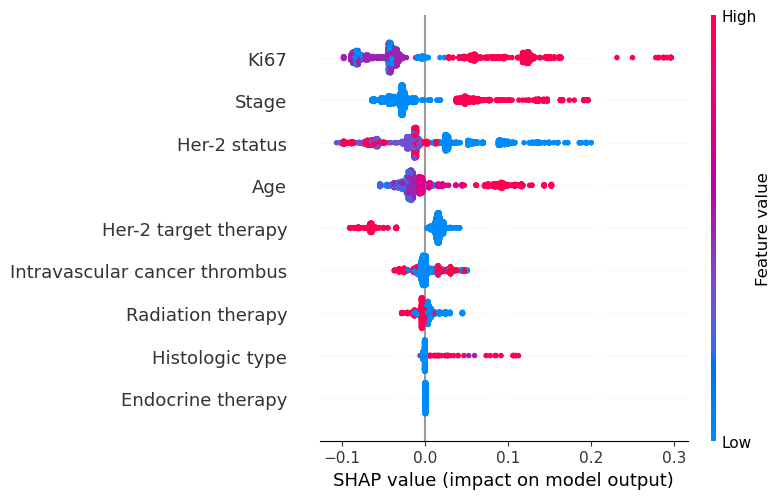

In [60]:
explainer = shap.TreeExplainer(rf_model)
data_pd = pd.DataFrame(data, columns=feature_name)
shap_values = explainer.shap_values(data_pd)
print("Random Forest Shap Plot")
shap.summary_plot(shap_values[1], data_pd)

  0%|          | 0/2395 [00:00<?, ?it/s]

MLP Shap Plot


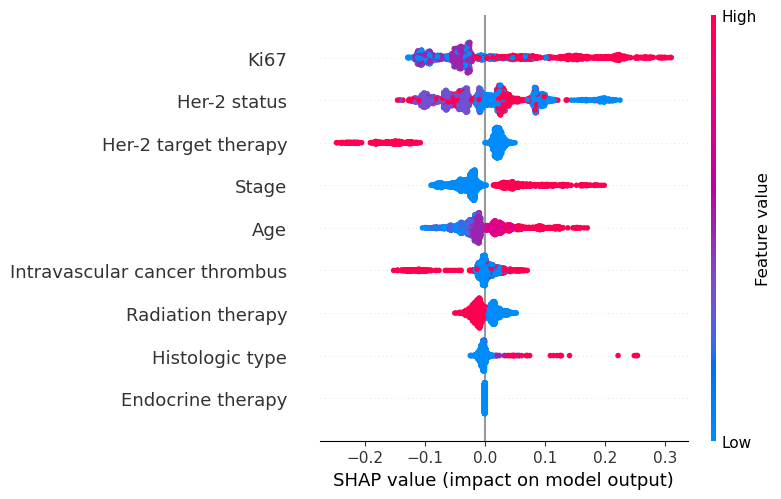

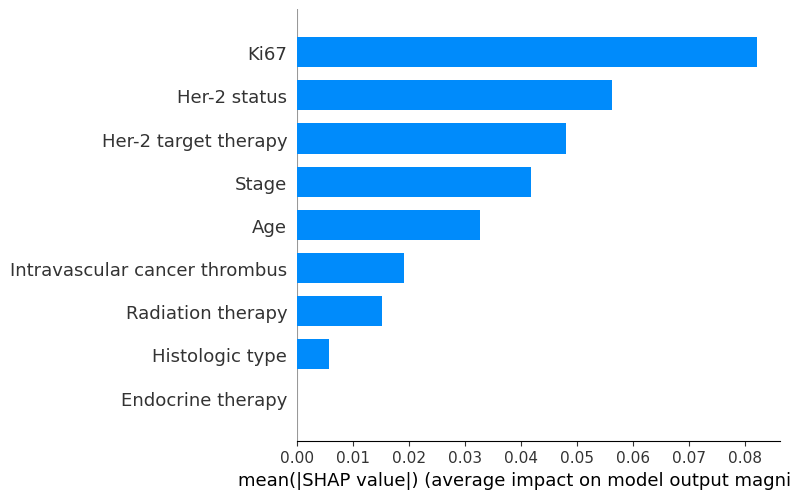

In [56]:
feature_name = ["Her-2 status", "Age", "Histologic type", "Intravascular cancer thrombus", "Endocrine therapy", "Radiation therapy", "Her-2 target therapy", "Ki67", "Stage"]
x_samples = shap.sample(np.array(x_train), 100)
explainer = shap.KernelExplainer(mlp_model.predict_proba, np.array(x_samples))
shap_values = explainer.shap_values(np.array(data), nsamples=100)
print("MLP Shap Plot")
shap.summary_plot(shap_values[1], np.array(data), feature_names=feature_name)
# shap.plots.scatter(shap_values[:,["Her-2 status"]],shap_values[:,["Her-2 status"]])
shap.summary_plot(shap_values[1], np.array(data), feature_names=feature_name, plot_type="bar")

In [61]:
import json
with open("./shap_os5/mlp_neg.json", "w") as file:
    json.dump(shap_values[1].tolist(), file)

In [62]:
her2_data = [d[0] for d in data]

her2_zero = []
her2_low = []
her2_pos = []
for i in range(len(her2_data)):
    if her2_data[i] == 0:
        her2_zero.append(shap_values[1][i][0])
    elif her2_data[i] == 1:
        her2_low.append(shap_values[1][i][0])
    elif her2_data[i] == 3:
        her2_pos.append(shap_values[1][i][0])

assert len(her2_low)+len(her2_pos)+len(her2_zero) == len(her2_data)

In [63]:
with open(f"./shap_os5/mlp_{mode}.json", "w") as file:
    json.dump({
        "her2_zero":her2_zero,
        "her2_low":her2_low,
        "her2_pos":her2_pos
    }, file)